In [1]:
import sys
import os
sys.path.append("../..")
import model 
import geopandas as gdp
import pandas as pd
import numpy as np
import scipy
from model.sim import location, state, contacts
from IPython.display import display
from timeit import default_timer as timer

In [2]:
crs = {'epsg:3857'}
shp_path = '../../../shp' # Change to your local shape file directory

In [3]:
posi = gdp.read_file(os.path.join(shp_path,"POSITIVOS_COVID_19.shp"))

print("Shape of posi df:", posi.shape)
print("Cols:", posi.columns)
posi.iloc[:,12:37]

Shape of posi df: (490, 47)
Cols: Index(['no_caso', 'no_caso_in', 'dia', 'semana', 'direccion', 'barrio',
       'comuna', 'municipio', 'departamen', 'nacionalid', 'tipo_doc',
       'fecha_not', 'sexo', 'edad', 'fecha_resu', 'estado_ate', 'lugar_aten',
       'atencion_h', 'fecha_hosp', 'fecha_de_a', 'fecha_recu', 'fecha_fall',
       'tipo_conta', 'pais_viaje', 'fecha_ingr', 'fecha_ini_', 'fecha_cons',
       'lugar_repo', 'pais_incid', 'fecha_2da_', 'resut_2da_', 'fecha_3ra_',
       'result_3ra', 'eps_fosyga', 'no_contact', 'sintomatic', 'asintomati',
       'trabajador', 'rango_etar', 'GlobalID', 'CreationDa', 'Creator',
       'EditDate', 'Editor', 'seexo', 'nuevo_barr', 'geometry'],
      dtype='object')


,sexo,edad,fecha_resu,estado_ate,lugar_aten,atencion_h,fecha_hosp,fecha_de_a,fecha_recu,fecha_fall,...,lugar_repo,pais_incid,fecha_2da_,resut_2da_,fecha_3ra_,result_3ra,eps_fosyga,no_contact,sintomatic,asintomati
0,1,21,2020-03-25,2,1,0,None,None,2020-04-10,None,...,Barranquilla,None,None,0,None,0,COOSALUD,0,6,13
1,2,50,2020-03-27,3,6,0,None,None,None,2020-03-27,...,Barranquilla,None,None,0,None,0,CAJACOPI,0,13,17
2,1,48,2020-04-01,2,1,0,None,None,2020-04-19,None,...,Barranquilla,None,None,0,None,0,CAJACOPI,0,0,8
3,2,13,2020-04-02,2,1,0,None,None,2020-04-19,None,...,Barranquilla,None,None,0,None,0,CAJACOPI,0,0,7
4,2,55,2020-04-03,2,1,0,None,None,2020-04-10,None,...,Barranquilla,None,None,0,None,0,COOSALUD,0,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2,81,2020-05-19,3,6,0,None,None,None,2020-05-10,...,None,None,None,0,None,0,CAJACOPI,0,0,0
486,2,46,2020-05-19,4,2,0,2020-05-10,None,None,None,...,None,None,None,0,None,0,CAJACOPI,0,0,0
487,2,63,2020-05-19,1,1,0,None,None,None,None,...,None,None,None,0,None,0,CAJACOPI,0,0,0
488,2,47,2020-05-19,1,1,0,None,None,None,None,...,None,None,None,0,None,0,SURA EPS,0,0,0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 <a list of 32 Text xticklabel objects>)

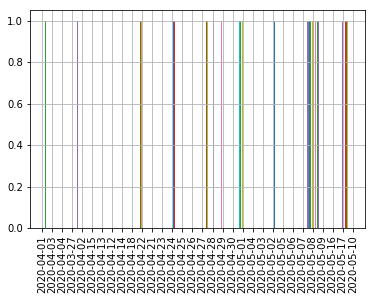

In [8]:
import matplotlib.pyplot as plt
posi.fecha_not.hist()
plt.xticks(rotation='vertical')

In [4]:
posi.geometry

0      POINT (-8323278.790 1224646.309)
1      POINT (-8327501.985 1222927.419)
2      POINT (-8327501.985 1222927.419)
3      POINT (-8327501.985 1222927.419)
4      POINT (-8327494.328 1222927.464)
                     ...               
485    POINT (-8327302.836 1222567.795)
486    POINT (-8322495.532 1224131.996)
487    POINT (-8322399.084 1223596.151)
488    POINT (-8325647.240 1224232.158)
489    POINT (-8323134.255 1222065.667)
Name: geometry, Length: 490, dtype: geometry

In [15]:
censo_viv = gdp.read_file(os.path.join(shp_path, "Censo_viviendas_manzanas_2018.shp"))
censo_viv

,DEPTO,MPIO,U_DPTO,U_MPIO,UA_CLASE,UA2_CPOB,UASECT_URB,UASECC_URB,UA_MANZANA,ID_UNIFICA,...,Shape__Are,Shape__Len,Shape__A_1,Shape__L_1,BARRIO,LOCALIDAD,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,01,05,0875810000000000010105,...,175966.132568,2390.008792,183608.321289,2443.258122,Zona Industrial Aeropuerto,Oriental,{04F4D3E7-AFD2-4539-AB52-0F8E246F7184},2443.258082,183608.307110,"POLYGON ((-8322903.569 1220895.450, -8322868.0..."
1,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,07,0875810000000000010207,...,948.752686,128.171769,990.019531,130.953570,La Esperanza,Oriental,{CF80ED78-A019-48AD-B370-B4AC06C60C1F},130.953496,990.020355,"POLYGON ((-8322730.480 1221783.628, -8322733.3..."
2,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,08,0875810000000000010208,...,2181.730103,209.853833,2276.641602,214.652118,La Esperanza,Oriental,{DCBE100D-26A7-4A4C-9F22-9507678E6BA2},214.652109,2276.639667,"POLYGON ((-8322960.592 1221835.106, -8322960.9..."
3,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,09,0875810000000000010209,...,1904.369385,195.713707,1987.211914,200.189418,La Esperanza,Oriental,{F24E357F-2F24-413F-BD09-65C56264DAFA},200.189439,1987.212097,"POLYGON ((-8322924.500 1221838.042, -8322925.3..."
4,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,10,0875810000000000010210,...,2066.300293,207.557934,2156.183594,212.325157,La Esperanza,Oriental,{29800C48-30A7-4425-8780-96736E5AD746},212.325120,2156.183976,"POLYGON ((-8322893.021 1221826.125, -8322893.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,22,0875810000000000410822,...,1720.528687,190.488461,1795.403320,194.292185,Las Colonias,Centro Norte,{783BA346-9464-4539-BFE4-F6D7845DFF70},194.292215,1795.404439,"POLYGON ((-8325748.385 1222319.577, -8325759.5..."
5960,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,23,0875810000000000410823,...,1189.348999,195.822394,1241.111328,199.756594,Las Colonias,Centro Norte,{3DDB6C55-CE55-4DBB-B555-05C5AD2CACF4},199.756574,1241.108727,"POLYGON ((-8325610.960 1222366.766, -8325610.9..."
5961,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,24,0875810000000000410824,...,1582.158813,221.862553,1651.001953,226.386830,Las Colonias,Centro Norte,{E0D78B3A-CE3B-4950-B381-8327FA61CF40},226.386958,1651.006337,"POLYGON ((-8325704.761 1222301.993, -8325701.8..."
5962,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,25,0875810000000000410825,...,829.561401,121.983859,865.661133,124.489633,Las Colonias,Centro Norte,{F7ADB177-966F-495E-A116-D790DAF30748},124.489525,865.659461,"POLYGON ((-8325728.880 1222282.951, -8325726.4..."


In [14]:
censo_pers = gdp.read_file(os.path.join(shp_path, "Censo_personas_manzanas_2018.shp"))
censo_pers

,DEPTO,MPIO,U_DPTO,U_MPIO,UA_CLASE,UA2_CPOB,UASECT_URB,UASECC_URB,UA_MANZANA,ID_UNIFICA,...,Shape__L_1,h,EDAD_20_60,pob,BARRIO,COMUNA,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,01,05,0875810000000000010105,...,2443.258257,1,0,0,Zona Industrial Aeropuerto,Oriental,{5B4B3BD7-50A7-4484-B0E5-3029B74A7B8E},2443.258062,183608.314843,"POLYGON ((-8322903.570 1220895.451, -8322868.0..."
1,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,07,0875810000000000010207,...,130.953499,9,8,0,La Esperanza,Oriental,{0AF04C46-B2B5-4076-B079-3E0D12A4BCBF},130.953763,990.019594,"POLYGON ((-8322730.482 1221783.629, -8322733.3..."
2,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,08,0875810000000000010208,...,214.652178,69,68,0,La Esperanza,Oriental,{18C2D6D8-8470-4840-B4EC-458464DE9BEA},214.652283,2276.638460,"POLYGON ((-8322960.593 1221835.108, -8322960.9..."
3,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,09,0875810000000000010209,...,200.189529,52,51,0,La Esperanza,Oriental,{71A178C7-9C94-48CF-97A0-57753AFB1132},200.189630,1987.208929,"POLYGON ((-8322924.501 1221838.043, -8322925.3..."
4,ATLÃNTICO,SOLEDAD,08,758,1,000,0001,02,10,0875810000000000010210,...,212.325244,69,68,0,La Esperanza,Oriental,{0825E96A-010B-438A-B97E-8C0B3D9701EB},212.325238,2156.185652,"POLYGON ((-8322893.023 1221826.126, -8322893.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,22,0875810000000000410822,...,194.292154,37,36,0,Las Colonias,Centro Norte,{9B37C570-25E8-46F0-8BC5-D95B02D5AB3F},194.292128,1795.402218,"POLYGON ((-8325748.386 1222319.578, -8325759.5..."
5960,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,23,0875810000000000410823,...,199.756804,25,24,0,Las Colonias,Centro Norte,{DE176271-02BD-4D3A-BA0C-D7668BBBE91E},199.756990,1241.110047,"POLYGON ((-8325610.961 1222366.767, -8325610.9..."
5961,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,24,0875810000000000410824,...,226.386854,70,69,0,Las Colonias,Centro Norte,{08202CBF-BF84-4F60-B250-90F70B7A33C3},226.387268,1651.008027,"POLYGON ((-8325704.762 1222301.994, -8325701.8..."
5962,ATLÃNTICO,SOLEDAD,08,758,1,000,0041,08,25,0875810000000000410825,...,124.489530,15,14,0,Las Colonias,Centro Norte,{17CCE116-8E40-4345-9E57-CD7A49188CA2},124.489611,865.659502,"POLYGON ((-8325728.881 1222282.952, -8325726.4..."


In [17]:
barrios_info = gdp.read_file(os.path.join(shp_path, "Barrios_info_DANE.shp"))
barrios_info_viv = gdp.read_file(os.path.join(shp_path, "Barrios_info_DANE_viv.shp"))

print(barrios_info.shape, barrios_info_viv.shape)
barrios_info

(232, 146) (230, 109)


,Id,BARRIO,area,COMUNA,GlobalID,CreationDa,Creator,EditDate,Editor,SEXO_M,...,EDAD_20_30,EDAD_30_40,EDAD_40_50,EDAD_50_60,EDAD_60_70,EDAD_70_80,EDAD_80_,SHAPE_Leng,SHAPE_Area,geometry
0,0,Las Gaviotas,103710.737439,Centro Norte,{DA37628A-E472-4563-A5D9-BAFBCE2FF0C5},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,729,634,450,498,253,82,55,1402.576086,108248.354443,"POLYGON ((-8326087.177 1223482.694, -8326093.8..."
1,1,Los Balkanes,58750.503679,Centro Norte,{DA43EBEF-6C64-42D0-9C20-DD7BFC415CFD},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,415,330,199,299,137,44,21,1351.145382,61321.163119,"POLYGON ((-8326179.153 1223953.715, -8326178.1..."
2,2,Las Gaviotas II,80384.347238,Centro Norte,{5E863F96-61BB-47DC-BB8C-C93613F2F7B8},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,442,396,214,319,130,46,22,1287.563635,83900.887961,"POLYGON ((-8326332.514 1223814.165, -8326332.0..."
3,3,Villa Del Carmen,133642.372386,Centro Norte,{35474DEC-962B-4E9A-98CA-26ECA152B775},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,903,926,547,562,428,149,54,2044.288018,139492.305424,"POLYGON ((-8325989.186 1224288.782, -8325980.7..."
4,4,Villa Cecilia,73397.793457,Centro Norte,{B0C1AB1E-49C7-4FE2-A458-51E1B9E75D93},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,460,420,287,294,211,67,40,1511.884412,76611.224183,"POLYGON ((-8325667.761 1224302.529, -8325662.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,232,Urb. DoÃ±a Manuela,86397.705219,Sur,{ADBAD27D-7E6F-444D-B7A0-6AFCFDF8CC2F},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,41,29,19,16,3,3,1,1209.594246,90159.860501,"POLYGON ((-8325635.418 1220109.041, -8325635.8..."
228,233,Matha Gisella,17258.161905,Sur,{89E33C14-9388-482D-ACDB-2BEA3012B914},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,77,59,64,40,16,6,3,962.446741,18009.666157,"POLYGON ((-8325367.587 1220198.725, -8325367.4..."
229,234,Urb. El Rio,113650.306502,Oriental,{135C8EB0-5CD7-4DF4-A219-B2E6E4DD8E52},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,426,457,423,273,297,193,60,1545.508143,118628.092480,"POLYGON ((-8323758.273 1224199.479, -8323758.7..."
230,199,Rigoberta Menchu,11870.886466,Oriental,{5910D49F-1C85-46B8-BD22-E13E05D2E601},2020-05-11,alcaldia_soledad,2020-05-11,alcaldia_soledad,0,...,0,0,0,0,0,0,0,1183.124958,12388.677412,"POLYGON ((-8322782.784 1221713.023, -8322779.2..."


In [38]:
print(list(barrios_info.columns))

['Id', 'BARRIO', 'area', 'COMUNA', 'GlobalID', 'CreationDa', 'Creator', 'EditDate', 'Editor', 'SEXO_M', 'SEXO_H', 'SEXO_TOTAL', 'EDAD_0_9', 'EDAD_10_19', 'EDAD_20_29', 'EDAD_30_39', 'EDAD_40_49', 'EDAD_50_59', 'EDAD_60_69', 'EDAD_70_79', 'EDAD_80_MA', 'OBJECTID_1', 'BARRIO_1', 'SEXO_M_1', 'SEXO_H_1', 'SEXO_TOT_1', 'EDAD_0_4', 'EDAD_5_9', 'EDAD_0_42', 'EDAD_15_19', 'EDAD_20_24', 'EDAD_25_29', 'EDAD_30_34', 'EDAD_35_39', 'EDAD_40_44', 'EDAD_45_49', 'EDAD_50_54', 'EDAD_55_59', 'EDAD_65_69', 'EDAD_60_64', 'EDAD_70_74', 'EDAD_75_79', 'EDAD_80_84', 'EDAD_85_89', 'EDAD_90_94', 'EDAD_95_99', 'EDAD_100_O', 'TOTAL_MAYO', 'GRUPO_ETNI', 'GRUPO_ET_1', 'GRUPO_ET_2', 'GRUPO_ET_3', 'GRUPO_ET_4', 'GRUPO_ET_5', 'GRUPO_ET_6', 'LUG_NAC_ES', 'LUG_NAC_OT', 'LUG_NAC__1', 'LUG_NAC_NO', 'TRATAMIENT', 'TRATAMIE_1', 'TRATAMIE_2', 'TRATAMIE_3', 'TRATAMIE_4', 'TRATAMIE_5', 'TRATAMIE_6', 'TRATAMIE_7', 'TRATAMIE_8', 'TRATAMIE_9', 'LO_ATENDIE', 'LO_ATEND_1', 'LO_ATEND_2', 'CALIDAD_SE', 'CALIDAD__1', 'CALIDAD__2', 'CA

In [39]:
barrios_info.centroid

0      POINT (-8325998.515 1223710.461)
1      POINT (-8326211.267 1223757.822)
2      POINT (-8326333.243 1223611.737)
3      POINT (-8325988.984 1224043.753)
4      POINT (-8325754.797 1224174.296)
                     ...               
227    POINT (-8325600.262 1220309.373)
228    POINT (-8325446.412 1220312.789)
229    POINT (-8323820.850 1224471.663)
230    POINT (-8322850.553 1221518.762)
231    POINT (-8324031.714 1221713.203)
Length: 232, dtype: geometry

In [32]:
print(list(barrios_info_viv.columns))

['Id', 'BARRIO', 'area', 'COMUNA', 'GlobalID', 'CreationDa', 'Creator', 'EditDate', 'Editor', 'SEXO_M', 'SEXO_H', 'SEXO_TOTAL', 'EDAD_0_9', 'EDAD_10_19', 'EDAD_20_29', 'EDAD_30_39', 'EDAD_40_49', 'EDAD_50_59', 'EDAD_60_69', 'EDAD_70_79', 'EDAD_80_MA', 'OBJECTID_1', 'BARRIO_1', 'TOTAL_VIVI', 'ESTRATO_1', 'ESTRATO_2', 'ESTRATO_3', 'ESTRATO_4', 'ESTRATO_5', 'ESTRATO_6', 'ESTRATO_NO', 'ESTRATO_SI', 'TIPO_VIVIE', 'TIPO_VIV_1', 'TIPO_VIV_2', 'TIPO_VIV_3', 'TIPO_VIV_4', 'TIPO_VIV_5', 'USO_VIVIEN', 'USO_MIXTO', 'USO_ESPECI', 'ENERGIA_EL', 'ENERGIA__1', 'ACUEDUCTO_', 'ACUEDUCTO1', 'ALCANTARIL', 'ALCANTAR_1', 'GAS_SI', 'GAS_NO', 'GAS_NO_SAB', 'RECOLECCIO', 'RECOLECC_1', 'INTERNET_S', 'INTERNET_N', 'INTERNET_1', 'VIVIENDA_P', 'VIVIENDA_1', 'VIVIENDA_V', 'VIVIENDA_D', 'EN_TERRITO', 'EN_TERRI_1', 'TERRITORIO', 'TERRITOR_1', 'AREA_PROTE', 'AREA_PRO_1', 'PARED_EN_B', 'PARED_EN_C', 'PARED_EN_M', 'PARED_EN_G', 'PARED_EN_T', 'PARED_EN_1', 'PARED_EN_2', 'PARED_EN_D', 'SIN_PAREDE', 'PISO_EN_MA', 'PISO_EN_

In [37]:
print(barrios_info["EDAD_70_74"].sum())
print(barrios_info["SEXO_TOT_1"].sum())
print(barrios_info_viv["ESTRATO_3"].sum())

8771


KeyError: 'ESTRATO_3'